In [1]:
from datetime import datetime
from distutils.util import strtobool
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


In [3]:
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("australian_electricity_demand_dataset.tsf")

In [4]:
loaded_data

,series_name,state,start_timestamp,series_value
0,T1,NSW,2002-01-01,"[5714.045004, 5360.189078, 5014.835118, 4602.7..."
1,T2,VIC,2002-01-01,"[3535.867064, 3383.499028, 3655.527552, 3510.4..."
2,T3,QUN,2002-01-01,"[3382.041342, 3288.315794, 3172.329022, 3020.3..."
3,T4,SA,2002-01-01,"[1191.078014, 1219.589472, 1119.173498, 1016.4..."
4,T5,TAS,2002-01-01,"[315.915504, 306.245864, 305.762576, 295.60219..."


In [5]:
len(loaded_data.iloc[1,3])

230736

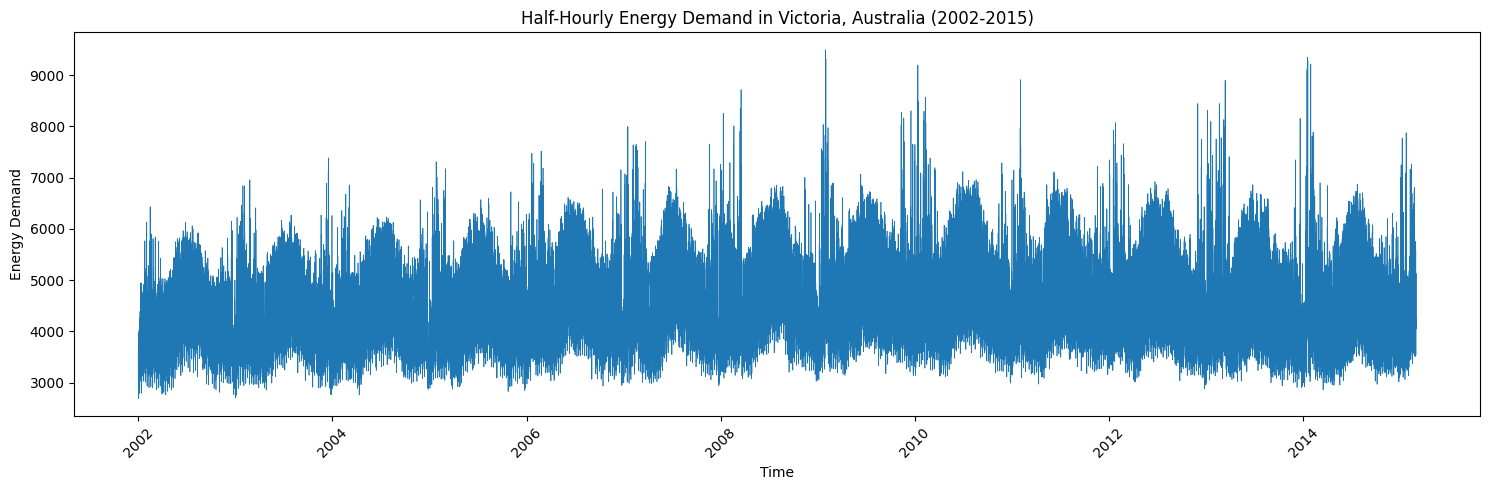

In [6]:
# Creating the line graph
vic_energy_demand = np.array(loaded_data.iloc[1,3])

# Generate a date range starting from 2002-01-01 with half-hourly frequency
dates = pd.date_range(start='2002-01-01', periods=230736, freq='30min')

# Creating a DataFrame
energy_data = pd.DataFrame({'DateTime': dates, 'demand': vic_energy_demand})
energy_data.set_index('DateTime', inplace=True)

# Plotting
plt.figure(figsize=(15, 5))  # Adjust the size for better visibility
plt.plot(energy_data.index, energy_data['demand'], linewidth=0.5)  # Thinner line for dense data

plt.title('Half-Hourly Energy Demand in Victoria, Australia (2002-2015)')
plt.xlabel('Time')
plt.ylabel('Energy Demand')

plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust subplot parameters
plt.show()


### Augmented Dickey-Fuller test

The ADF statistic is compared against critical values for different confidence levels. A p-value less than 0.05 typically suggests the series is stationary.

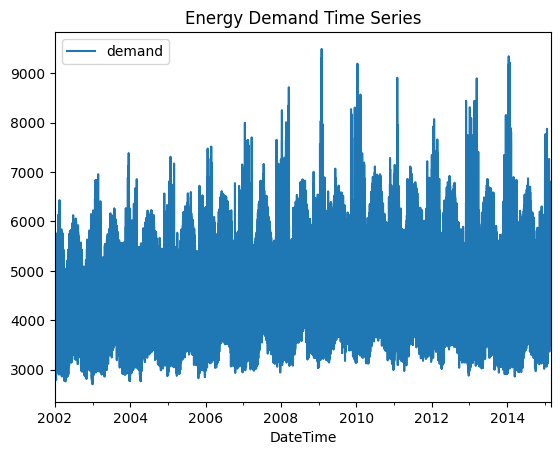

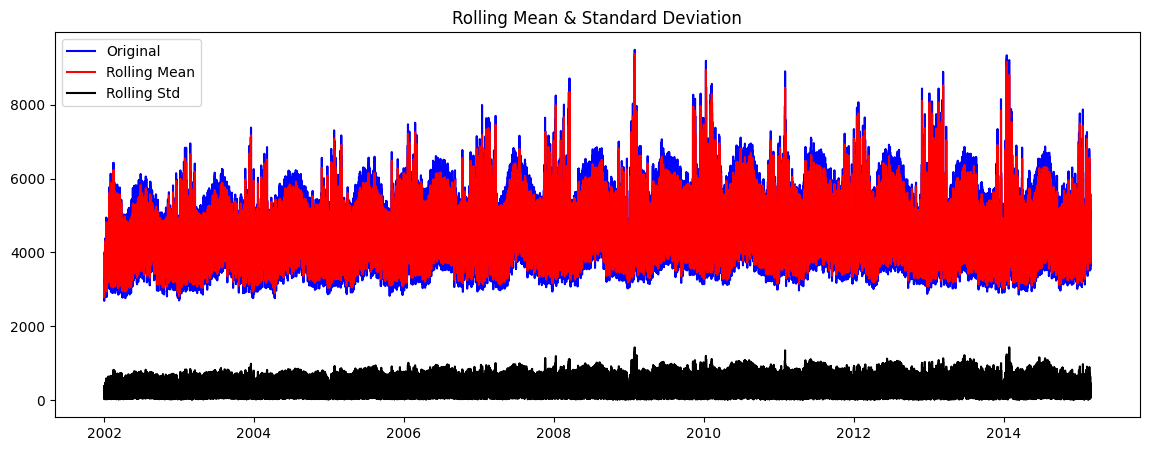

ADF Statistic: -34.341305
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
The time series is stationary.


In [7]:
# Plot the time series
energy_data.plot(title='Energy Demand Time Series')
plt.show()

# Calculate rolling statistics
rolling_mean = energy_data.rolling(window=12).mean()
rolling_std = energy_data.rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(14, 5))
plt.plot(energy_data, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()



# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(energy_data)

# Output the test results
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")
    

The validity of a time series being stationary can be established through both quantitative and visual analysis. Here's how the graph and the p-value from the Augmented Dickey-Fuller (ADF) test substantiate the stationarity of your time series:

### From the ADF Test (Quantitative Analysis):

- **ADF Statistic**: The ADF test statistic is significantly lower than any of the critical values at common confidence levels (1%, 5%, and 10%). This suggests that the null hypothesis of the presence of a unit root can be rejected with high confidence.
- **P-Value**: A p-value near zero (much lower than the conventional alpha level of 0.05) indicates strong evidence against the null hypothesis. This means that it's highly likely that the series is stationary.

### From the Graphs (Visual Analysis):

- **Time Series Plot**: The energy demand appears to fluctuate within a certain range over the entire time span without showing a long-term upward or downward trend. This is a characteristic of a stationary series where the mean level does not change over time.
- **Rolling Statistics**: The rolling mean and standard deviation plots do not show any visible trend, and they seem to be oscillating around a constant mean with a consistent spread.
